In [1]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from multiprocessing.pool import ThreadPool
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely import GEOSException

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
import seaborn as sns
sns.set_theme()

In [4]:
PARALLEL_PROCESSES = 16

In [5]:
def load_json(filename):
    with open('data/' + filename, 'r') as f:
        return json.load(f)

In [6]:
def get_coords(points):
    shapes = []
    if type(points[0]) is dict:
        coords = []
        for p in points:
            coords.append([p.get('lat'), p.get('lng')])
        shapes.append(coords)
        return shapes
    for p in points:
        shapes.append(np.column_stack([p[1::2], p[::2]]))
    return shapes

In [7]:
# Boundaries of Ukraine
ua_outline = gpd.read_file('stanford.geojson')
# CRS already set
# ua_outline = ua_outline.set_crs('EPSG:4326')
outline = ua_outline['geometry'].iloc[0]

<AxesSubplot: >

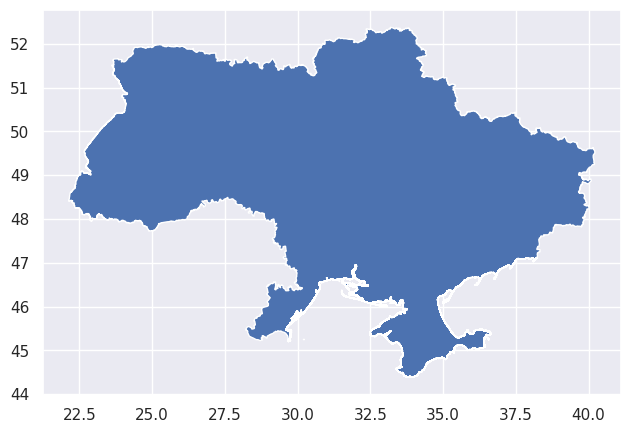

In [8]:
ua_outline.plot()

In [9]:
def extract_shapes(f):
    
    shape_dicts = [] 

    for field_id, field_dict in f['fields'].items():
        
        # Recaptured areas are not Russian-controlled, to skip them
        if field_dict.get('name') == 'Ukraine recaptured':
            continue
        # Same for "Territories, liberated from Russian forces"
        if 'liberated from Russian' in field_dict.get('description'):
            continue

        c = get_coords(field_dict['points'])

        if len(c) == 0:
            # Simple polygon
            if len(c[0] >= 3):
                # Only at least 3 points can form a valid polygon, prevent errors later on
                polygon = Polygon(c[0])
        else:
            # Multiple polygons, to be combined
            polygon_list = []
            for coord_pair in c:
                if len(coord_pair) >= 4:
                    # Prevent 'ValueError: A linearring requires at least 4 coordinates.'
                    polygon_list.append(Polygon(coord_pair))
            polygon = MultiPolygon(polygon_list)

        shape_dict = dict(id=field_id, name=field_dict['name'], geometry=polygon)
        shape_dicts.append(shape_dict)
        
        # XXX TEMP: Get area of occupied Crimea
        #if field_dict.get('name') == 'Occupied Crimea':
        #    cea = gpd.GeoDataFrame([shape_dict])
        #    cea = cea.set_crs('EPSG:4326')
        #    cea = cea.to_crs({'proj':'cea'})
        #    print(f"Area of Crimea: {float(round(cea.area / 1e6, 2))}")
        # -> Area: 26689.32

    
    return shape_dicts

In [10]:
def process_item(args):
    idx, filename = args
    print(f"(Processing {idx}", end='\r')
    
    f = load_json(filename)
    id_ = filename.split('.json')[0]
    date = datetime.fromtimestamp(int(id_))
    
    shape_dicts = extract_shapes(f)
    
    ua_territory = gpd.GeoDataFrame(shape_dicts)
    ua_territory = ua_territory.set_crs('EPSG:4326')
    
    # Resolve some issues with data
    ua_territory['geometry'] = ua_territory.geometry.buffer(0)
    
    try:
        ua_territory['intersects'] = ua_territory['geometry'].intersects(outline)
    except GEOSException as e:
        print(f"filename: {filename}, Error: {e}")
        # In case of errors, show the affected area
        print(ua_territory)
        ua_territory.plot()
        raise
        
    # Drop areas entirely outside Ukrainian bounds
    # Prevents an error message when running .intersection() next
    ua_territory = ua_territory[ua_territory['intersects'] == True]
    # Reduce controlled areas to inside Ukrainian bounds
    try:
        ua_territory['geometry'] = ua_territory['geometry'].intersection(outline)
    except GEOSException as e:
        print(f"filename: {filename}, Error: {e}")
        # In case of errors, show the affected area
        print(ua_territory)
        ua_territory.plot()
        raise
        
    joined = ua_territory.dissolve(by=None).iloc[0]

    # Drop unneeded boolean column
    ua_territory = ua_territory.drop(['intersects'], axis=1)
    
    ua_territory = ua_territory.to_crs({'proj': 'cea'})
    ua_territory['area'] = ua_territory['geometry'].area / 10**6
    
    area = ua_territory['area'].sum()
    
    return [id_, date, area, joined]

In [11]:
processed = []
files = sorted(os.listdir('data'))

In [12]:
def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_item, enumerate(items, 1)))

In [13]:
# XXX this may be slow, takes about 2min 
#processed = dispatch(files[:])

In [5]:
import pickle

In [15]:
#with open('dump.pickle', 'wb') as f:
#pickle.dump(processed, f)

In [6]:
with open('dump.pickle', 'rb') as f:
    processed = pickle.load(f)

In [7]:
df = pd.DataFrame(processed, columns=['id', 'date', 'area', 'features'])

In [8]:
df = df.drop(['id'], axis=1)
df = df.sort_values(by='date', ascending = True)

In [9]:
df = df.set_index('date')

In [10]:
df['area'] = df['area'].astype('float')
# Calculate change to previous day which translates to daily gains/losses
df['change'] = df['area'].diff()

# Smooth over outliers or faulty data

Data from 2022-05-15 until 2022-05-19 shows outlier spikes as well as 2022-08-25 which is most likely a bug and not reflective of actual battlefield developments. Fix this by backfilling data from the previous day.

In [11]:
adjusted = df.copy()
# Fix outliers
adjusted['2022-05-15':'2022-05-19'] = adjusted[adjusted.index == '2022-05-14'].values
adjusted.loc[adjusted.index == '2022-08-25'] = adjusted[adjusted.index == '2022-08-24'].values
# Recompute changed area
adjusted['change'] = adjusted['area'].diff()
# df[(df.index <= datetime(2022, 5, 30)) & (df.index >= datetime(2022, 5, 1))]
# df['2022-05-10':'2022-05-30']

In [12]:
from ipyleaflet import (
    Map, GeoData, GeoJSON, basemaps, MagnifyingGlass, basemap_to_tiles,
    LayerGroup, SplitMapControl, LayersControl, LegendControl,
)
import ipywidgets

In [23]:
selection_slider = ipywidgets.SelectionSlider(options=list(adjusted.index),
                                              value=adjusted.index[0].to_pydatetime(), # datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

In [24]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(48.1928465, 37.8562077), zoom=5)

def plot_date(date):
    entry = adjusted.loc[adjusted.index == date]
    idx, row = next(entry.iterrows())
    geo_data = GeoData(geo_dataframe=gpd.GeoDataFrame(
        geometry=[row['features']['geometry'],]  #gpd.GeoSeries(row['features']['geometry']))
    ))
    # Clear potential overlays from previous day selection
    m.clear_layers()
    m.add_layer(geo_data)

ipywidgets.interact(plot_date, date=selection_slider)
display(m)

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', options=(Timestamp('2022-…

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [25]:
#adjusted['area'].to_json('territory.json')

In [26]:
#adjusted['area'].to_csv('territory.csv')

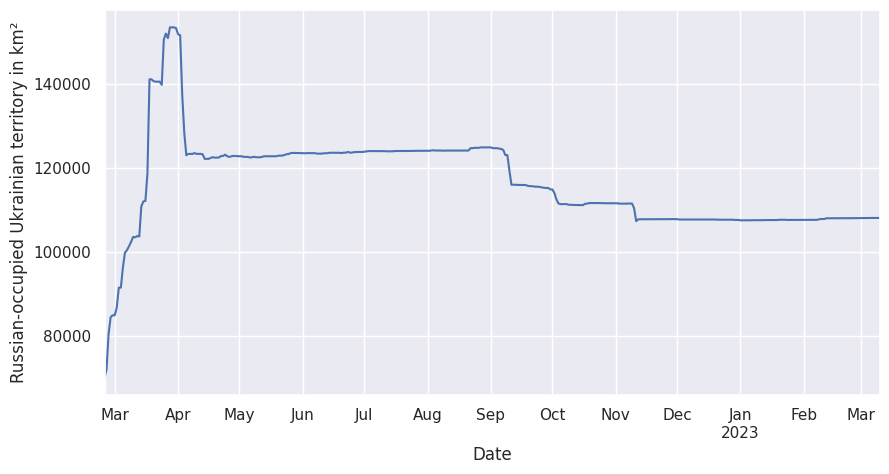

In [50]:
plt.figure() #  figsize=(12, 5)
adjusted['area'].plot(xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km\u00b2')
plt.savefig('liveuamap_area_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_area_total.png', bbox_inches='tight', dpi=600)

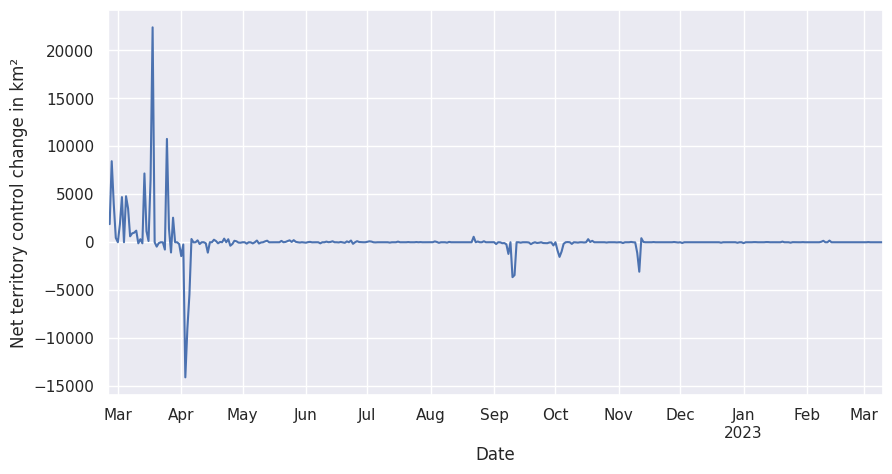

In [28]:
plt.figure()
adjusted['change'].plot(xlabel='Date', ylabel='Net territory control change in km\u00b2')
plt.savefig('liveuamap_area_net.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_area_net.png', bbox_inches='tight', dpi=600)

In [29]:
with open('eyesonrussia_missile_counts.json', 'rb') as f:
    eyesonrussia = json.load(f)

In [30]:
eor = pd.DataFrame.from_dict(eyesonrussia, orient='index', columns=['events'])

In [31]:
#pd.to_datetime(eor.index.values)
#pd.to_numeric(eor.index)
eor.index = pd.to_datetime(eor.index, unit='ms')

<AxesSubplot: >

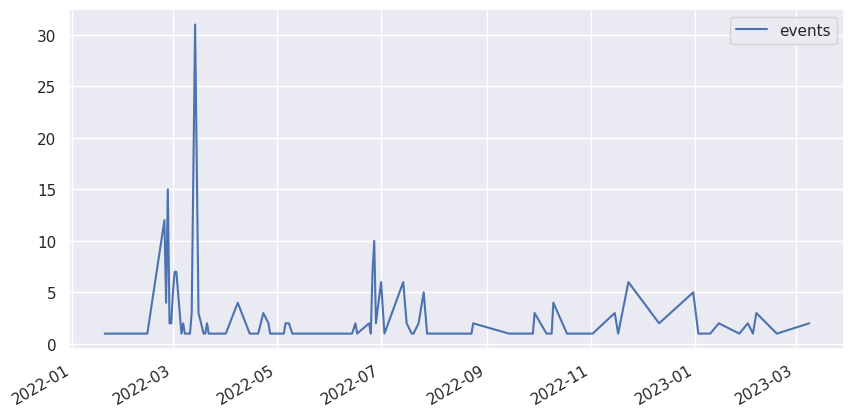

In [32]:
eor.plot()

In [56]:
with open('nzz_area_occupied.json', 'rb') as f:
    nzz_raw = json.load(f)

In [57]:
nzz = pd.DataFrame.from_dict(nzz_raw, orient='index', columns=['area'])

In [58]:
nzz.index = pd.to_datetime(nzz.index)

In [59]:
CRIMEA_AREA = 26689.32
nzz['area'] = nzz['area'] + CRIMEA_AREA

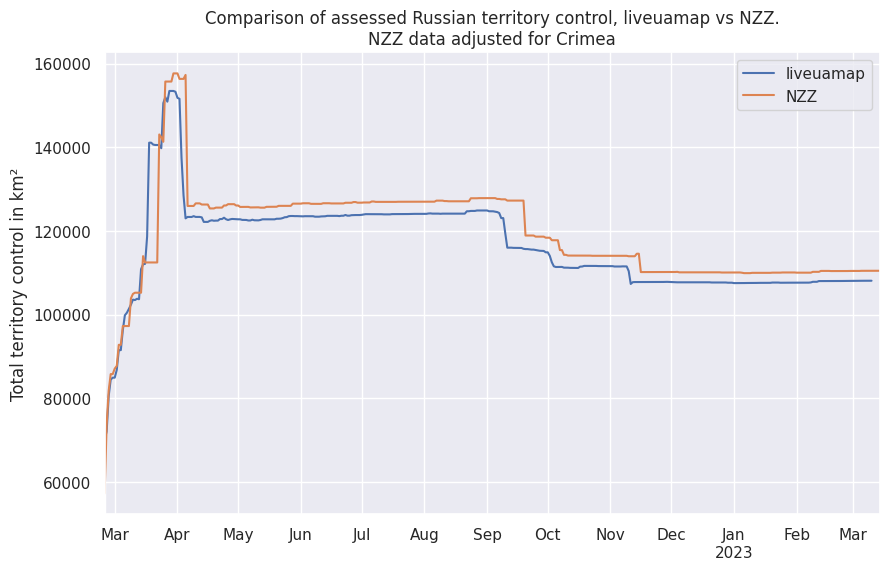

In [60]:
plt.figure()
ax = adjusted['area'].plot(xlabel='', ylabel='Total territory control in km\u00b2', figsize=(10, 6))
nzz['area'].plot(ax=ax)
plt.title('Comparison of assessed Russian territory control, liveuamap vs NZZ.\nNZZ data adjusted for Crimea')
ax.legend(['liveuamap', 'NZZ'], loc='upper right')
plt.savefig('liveuamap_nzz_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_nzz_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()

In [38]:
comparison = adjusted['area'] - nzz['area']

Text(0.5, 1.0, 'Difference in NZZ vs liveuamap total territory control in km²')

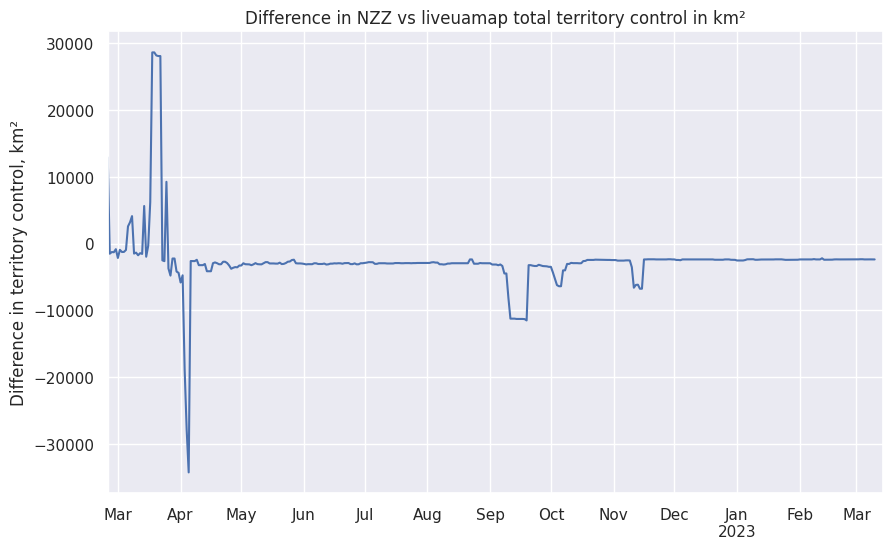

In [39]:
plt.figure()
comparison.plot(xlabel='', ylabel='Difference in territory control, km\u00b2', figsize=(10, 6))
plt.title('Difference in NZZ vs liveuamap total territory control in km\u00b2')

In [40]:
with open('nzz.pickle', 'rb') as f:
    nzz_dump = pickle.load(f)

In [41]:
nzz_df = pd.DataFrame(nzz_dump, columns=['id', 'date', 'area', 'features'])
nzz_df = nzz_df.drop(['id'], axis=1)
nzz_df = nzz_df.sort_values(by='date', ascending = True)
nzz_df = nzz_df.set_index('date')
nzz_df['area'] = nzz_df['area'].astype('float')
CRIMEA_AREA = 26689.32
nzz_df['area'] = nzz_df['area'] + CRIMEA_AREA

In [42]:
selection_slider = ipywidgets.SelectionSlider(options=list(adjusted.index),
                                              value=adjusted.index[0].to_pydatetime(), # datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(48.1928465, 37.8562077), zoom=5)

#bg = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
#m.add_layer(bg)

lg_liveuamap = LayerGroup(name='liveuamap', layers=[])
m.add_layer(lg_liveuamap)
lg_nzz = LayerGroup(name='NZZ', layers=[])
m.add_layer(lg_nzz)
#control = SplitMapControl(left_layer=lg_nzz, right_layer=lg_liveuamap)
lcontrol = LayersControl(position='topright')
#control = SplitMapControl(left_layer=lg_liveuamap, right_layer=lg_nzz)
#m.add_control(control)
m.add_control(lcontrol)
legend = LegendControl({"NZZ":"red", "liveuamap": "blue"}, name="Legend", position="bottomright")
m.add_control(legend)
    
def plot_liveuamap(date):
    entry = adjusted.loc[adjusted.index == date]
    idx, row = next(entry.iterrows())
    geo_data = GeoData(
        geo_dataframe=gpd.GeoDataFrame(geometry=[row['features']['geometry'],],),
        style={
            'color': 'blue',
            'fillcolor': 'blue',
            'opacity': 1.0,
        },
    )
    #print(str(geo_data)[:100])
    # Clear potential overlays from previous day selection
    lg_liveuamap.clear_layers()
    lg_liveuamap.add_layer(geo_data)

def plot_nzz(date):
    entry = nzz_df.loc[nzz.index == date]
    idx, row = next(entry.iterrows())
    features = row.loc['features']
    fc =   {
        'type': 'FeatureCollection',
        'features': features,
    }
    geo_json = GeoJSON(
        data=fc,
        style={
            'color': 'red',
            'fillcolor': 'red',
            'opacity': 0.5,
        },
    )
    # Clear potential overlays from previous day selection
    lg_nzz.clear_layers()
    lg_nzz.add_layer(geo_json)
    
def plot_date(date):
    plot_liveuamap(date)
    plot_nzz(date)

ipywidgets.interact(plot_date, date=selection_slider)
display(m)

# control = SplitMapControl(left_layer=lg_liveuamap, right_layer=lg_nzz)
#m.add_control(control)
#ipywidgets.HBox([m, Map(center=[43.6, 1.44], zoom=10)])

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', options=(Timestamp('2022-…

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [43]:
combined = pd.concat([adjusted['area'], nzz_df['area']], axis=1, keys=['area_liveuamap', 'area_nzz'])

In [44]:
combined['avg'] = combined.median(axis=1, numeric_only=True)
combined['avg_change'] = combined['avg'].diff()

<Figure size 1000x500 with 0 Axes>

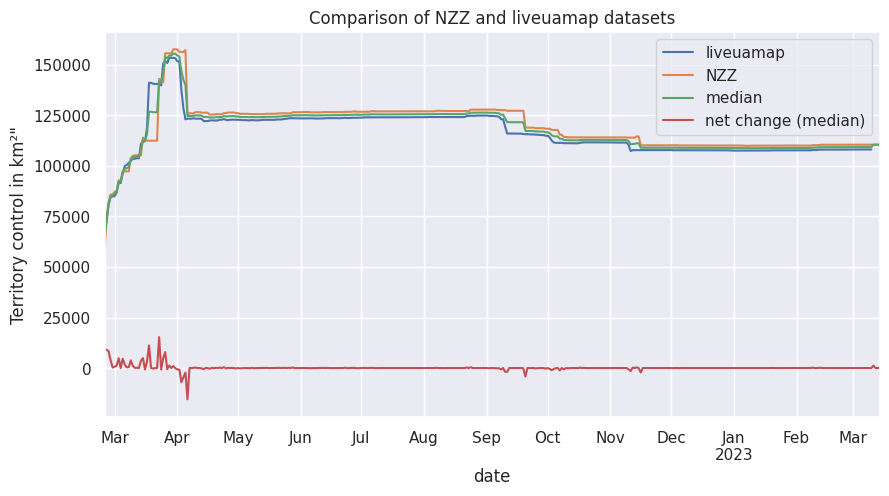

In [45]:
plt.figure()
ax = combined.plot(figsize=(10, 5))
plt.title('Comparison of NZZ and liveuamap datasets')
ax.set_ylabel('Territory control in km\u00b2"')
#ax.legend(['Total territory control (averaged) in km\u00b2'], loc='best')
ax.legend([
    'liveuamap',
    'NZZ',
    'median',
    'net change (median)',
])
plt.savefig('comparison_liveuamap_nzz_median.svg', bbox_inches='tight', dpi=600)
plt.savefig('comparison_liveuamap_nzz_median.png', bbox_inches='tight', dpi=600)

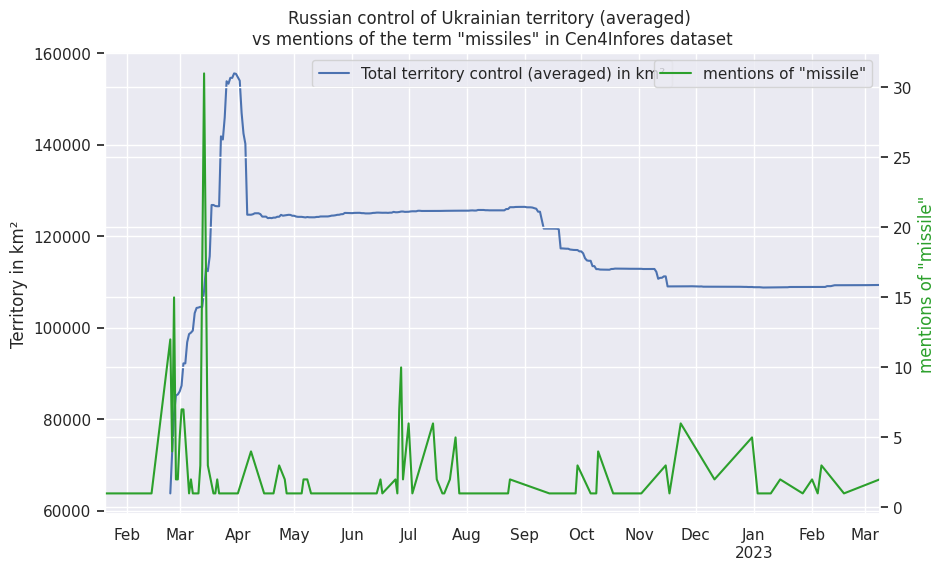

In [46]:
plt.figure()
ax = combined['avg'].plot(xlabel='', ylabel='Territory in km\u00b2', figsize=(10, 6))
ax2 = ax.twinx()
ax2.set_ylabel('mentions of "missile"', color='tab:green')
eor.plot(ax=ax2, color='tab:green')
plt.title('Russian control of Ukrainian territory (averaged) \nvs mentions of the term "missiles" in Cen4Infores dataset')
ax.legend(['Total territory control (averaged) in km\u00b2'], loc='upper center')
ax2.legend(['mentions of "missile"'], loc='upper right')
plt.savefig('comparison_territory_total_missiles_eor.svg', bbox_inches='tight', dpi=600)
plt.savefig('comparison_territory_total_missiles_eor.png', bbox_inches='tight', dpi=600)
plt.show()

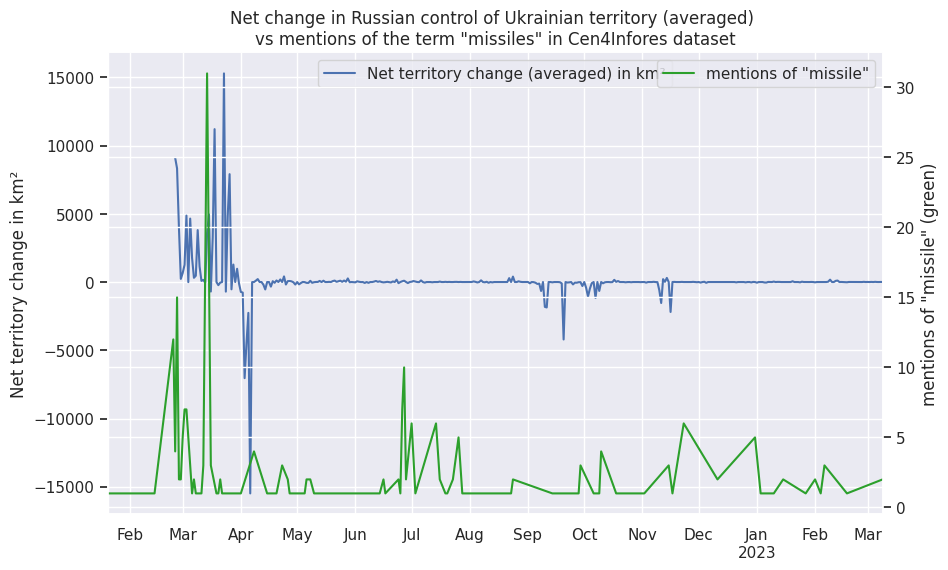

In [47]:
plt.figure(figsize=(10, 6))
ax = combined['avg_change'].plot(xlabel='', ylabel='Net territory change in km\u00b2', logy=False)
ax2 = ax.twinx()
ax2.set_ylabel('mentions of "missile" (green)')
eor.plot(ax=ax2, color='tab:green', logy=False)
plt.title('Net change in Russian control of Ukrainian territory (averaged) \nvs mentions of the term "missiles" in Cen4Infores dataset')
ax.legend(['Net territory change (averaged) in km\u00b2'], loc='upper center')
ax2.legend(['mentions of "missile"'], loc='upper right')
plt.savefig('comparison_territory_net_missiles_eor.svg', bbox_inches='tight', dpi=600)
plt.savefig('comparison_territory_net_missiles_eor.png', bbox_inches='tight', dpi=600)
plt.show()

In [48]:
eor['events'].corr(combined['avg_change'])

0.28743753102741526

In [49]:
np.log(eor['events'])

2022-01-20    0.000000
2022-01-27    0.000000
2022-02-14    0.000000
2022-02-24    2.484907
2022-02-25    1.386294
                ...   
2023-02-01    0.693147
2023-02-04    0.000000
2023-02-06    1.098612
2023-02-18    0.000000
2023-03-09    0.693147
Name: events, Length: 93, dtype: float64

In [50]:
np.log(combined['avg_change'])

/home/me/.virtualenvs/vp/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/me/.virtualenvs/vp/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


date
2022-02-24         NaN
2022-02-25    9.115513
2022-02-26    9.027203
2022-02-27    8.290794
2022-02-28    5.432950
                ...   
2023-03-10        -inf
2023-03-11    7.082645
2023-03-12        -inf
2023-03-13        -inf
2023-03-14         NaN
Freq: D, Name: avg_change, Length: 384, dtype: float64

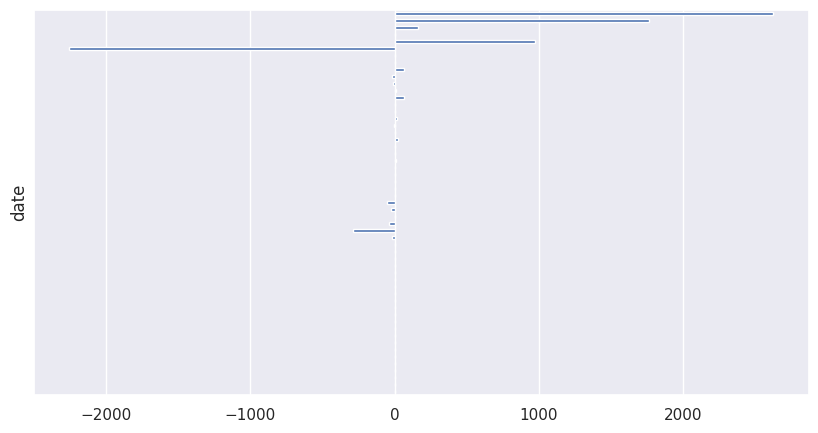

In [51]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
resampled = combined['avg_change'].resample("7D").median()
# ax = resampled[::-1].plot.bar()
ax = resampled.plot.barh()
ax.set_yticks([])

# Set major and minor date tick locators
#maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
#ax.yaxis.set_major_locator(maj_loc)
#min_loc = mdates.MonthLocator()
#ax.yaxis.set_minor_locator(min_loc)

# Set major date tick formatter
#zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
#maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
#ax.yaxis.set_major_formatter(maj_fmt)

# ax.figure.autofmt_xdate(rotation=90, ha='center')
# ax.set_xlim(combined.index.min(), combined.index.max());

plt.gca().invert_yaxis()

plt.savefig('net_change_barh.svg', bbox_inches='tight', dpi=600)
plt.savefig('net_change_barh.png', bbox_inches='tight', dpi=600)

In [59]:
#import pylab as pl
#plt.figure()
#ax = plt.gca()
#ax.hexbin(pl.date2num(combined.index), pl.date2num(combined['avg_change']), gridsize=20)
#ax.xaxis_date()
#ax.yaxis_date()
#ax.xaxis.major.formatter.scaled[1.0] = "%Y-%m-%d"
#ax.yaxis.major.formatter.scaled[1.0] = "%Y-%m-%d"
#pl.xticks(rotation=45)

In [45]:
novaya = pd.read_csv('dataset-territory.csv',
                     sep='\s+', skiprows=1, header=None,
                     names=['date', 'territory'], index_col='date',
                    infer_datetime_format=True, parse_dates=True)
novaya['territory'] = novaya['territory'].str.replace(',', '.').astype(float)

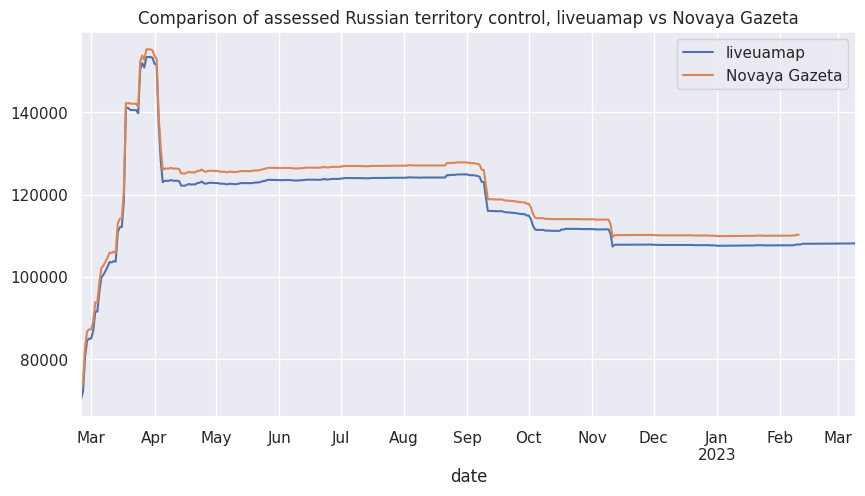

In [54]:
plt.figure()
ax = adjusted['area'].plot()
novaya['territory'].plot(ax=ax)
plt.title('Comparison of assessed Russian territory control, liveuamap vs Novaya Gazeta')
ax.legend(['liveuamap', 'Novaya Gazeta'], loc='upper right')
plt.savefig('liveuamap_novaya_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_novaya_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()

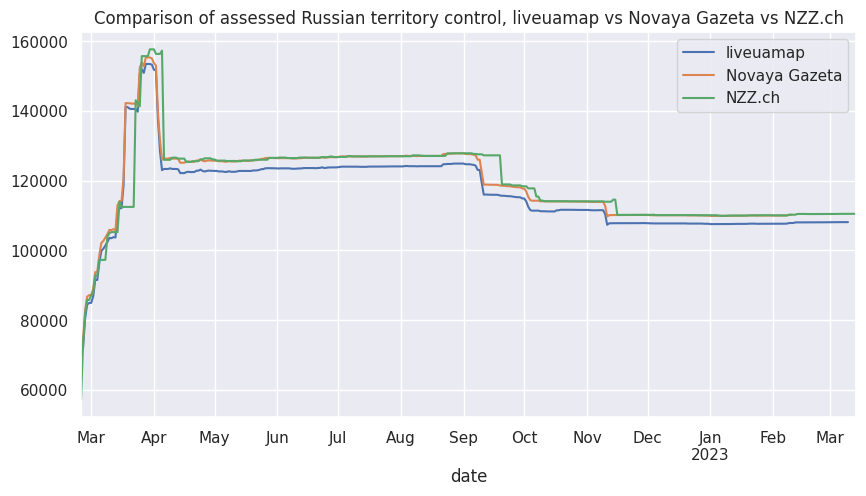

In [61]:
plt.figure()
ax = adjusted['area'].plot()
novaya['territory'].plot(ax=ax)
nzz['area'].plot(ax=ax)

plt.title('Comparison of assessed Russian territory control, liveuamap vs Novaya Gazeta vs NZZ.ch')
ax.legend(['liveuamap', 'Novaya Gazeta', 'NZZ.ch'], loc='upper right')
plt.savefig('liveuamap_novaya_nzz_area_comparison_total.svg', bbox_inches='tight', dpi=600)
plt.savefig('liveuamap_novaya_nzz_area_comparison_total.png', bbox_inches='tight', dpi=600)
plt.show()